In [1]:
import numpy as np
import soundfile as sf
from keras.models import load_model
from librosa.core import istft, load, stft, magphase
import librosa
import librosa.display
import museval
import matplotlib.pyplot as plt

In [2]:
# !pip install ffmpeg
# !pip install stempeg
# !pip install museval
# !pip install --upgrade pip

In [69]:
mixture = r'F:\BEX IV I\python\ML\song sample\069 - Hollow Ground - Left Blind/mixture.wav'

In [115]:
#load model
model = load_model('F:\BEX IV I\python\ML\model\model/vocal.h5')

In [116]:
# SR =  44100
window_size = 1024
hop_length = 690

patch_size = 128
EPOCH = 1
BATCH = 16
SAMPLING_STRIDE = 10

In [117]:
complete_MIX, SR = load(mixture,sr=44100)
MIX, SR = load(mixture,sr=44100, offset=0.0, duration=2.0)

original_signal_spectrogram = stft(complete_MIX, n_fft=window_size, hop_length=hop_length)

(513, 10181)


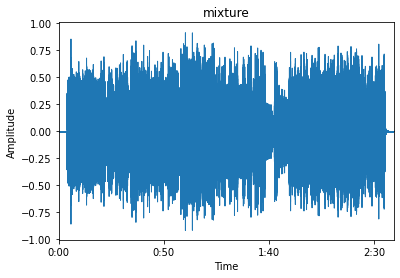

In [118]:
librosa.display.waveplot(complete_MIX, sr=SR)
plt.title('mixture')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


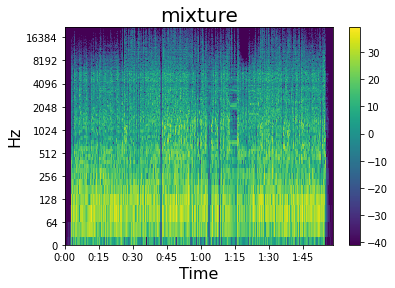

In [119]:
mix_wav_mag, mix_wav_phase = magphase(original_signal_spectrogram)
plt.title('mixture', fontsize=20)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Hz", fontsize=16)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(original_signal_spectrogram)), sr = SR, x_axis = 'time', y_axis = 'log',cmap='viridis')
plt.colorbar()

In [121]:
#predict output of whole audio signal
i=0
for x in range(len(complete_MIX)//len(MIX)):
  MIX, SR = load(mixture,sr=44100, offset=2.0*i, duration=2.0)
  spectrogram = stft(MIX, n_fft=window_size, hop_length=hop_length)
  mix_wav_mag, mix_wav_phase = magphase(spectrogram)
  
  mix_wav_mag1=mix_wav_mag[:, 0:128]
  mix_wav_phase1=mix_wav_phase[:, 0:128]
  
  X=mix_wav_mag1[1:].reshape(1, 512, 128, 1)
  y=model.predict(X, batch_size=16)  
  target_pred_mag = np.vstack((np.zeros((128)), y.reshape(512, 128)))

  output = librosa.core.istft(target_pred_mag*mix_wav_phase1, win_length=window_size, hop_length=hop_length)
  
  if(i==0):
    mag = output
  else:
    mag=np.concatenate((mag,output),axis=None)
  i=i+1

In [122]:
print(len(mag))
predict_spectrogram = stft(mag, n_fft=window_size, hop_length=hop_length)
print(predict_spectrogram.shape)
original_signal_spectrogram_back=original_signal_spectrogram[:, 0:predict_spectrogram.shape[1]]
print(original_signal_spectrogram_back.shape)
mask =np.abs(predict_spectrogram) / (np.maximum(np.abs(predict_spectrogram), np.abs(original_signal_spectrogram_back)) + 1e-8)

6922770
(513, 10034)
(513, 10034)


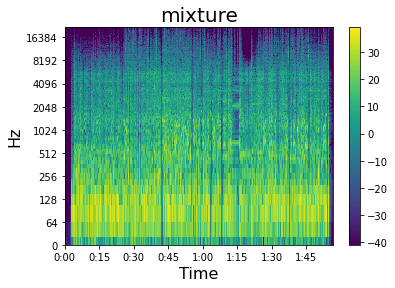

In [124]:
plt.title('mixture', fontsize=20)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Hz", fontsize=16)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(original_signal_spectrogram_back)), sr = SR, x_axis = 'time', y_axis = 'log',cmap='viridis')
plt.colorbar()

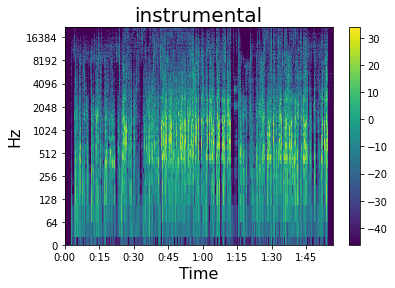

In [125]:
plt.title('instrumental', fontsize=20)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Hz", fontsize=16)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(predict_spectrogram)), sr = SR, x_axis = 'time', y_axis = 'log',cmap='viridis')
plt.colorbar()

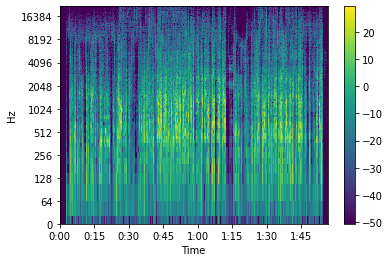

In [126]:
librosa.display.specshow(librosa.amplitude_to_db(np.multiply(original_signal_spectrogram_back,mask)), sr = SR, x_axis = 'time', y_axis = 'log',cmap='viridis')
plt.colorbar()

(513, 10034)


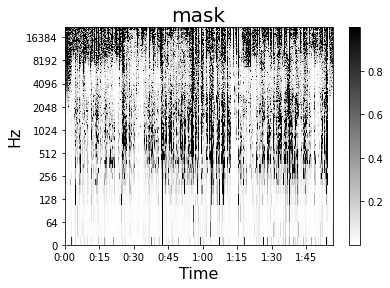

In [127]:
print(mask.shape)
plt.title('mask', fontsize=20)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Hz", fontsize=16)
librosa.display.specshow(mask, sr = SR, x_axis = 'time', y_axis = 'log',cmap='gray_r')
plt.colorbar()

In [129]:
write_path=r'F:\BEX IV I\python\ML\song sample\069 - Hollow Ground - Left Blind/vocalout.wav'
sf.write(write_path, mag , SR)

In [21]:
original_signal_path = '/content/drive/MyDrive/modell/sample song 2 sec/AM Contra - Heart Peripheral/vocal.wav'
original_signal_vocal, SR = load(original_signal_path,sr=44100)
original_signal = complete_MIX-original_signal_vocal
original_signal_back = original_signal[:len(mag)]
print(len(original_signal))
print(len(original_signal_back))
print(len(mag))
sdr,_,_,sar,_ = museval.metrics.bss_eval(original_signal_back, mag,window=np.inf)
print('sdr: ',sdr[0][0])
print('sar: ',sar[0][0])

88200
87630
87630
sdr:  -0.9188713899602876
sar:  -12.821051495464486


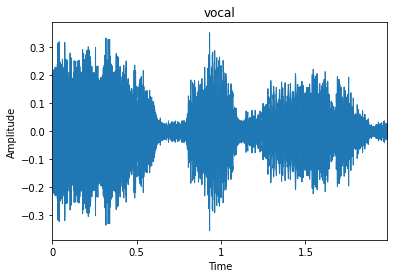

In [22]:
plt.title('vocal')
plt.xlabel("Time")
plt.ylabel("Amplitude")

librosa.display.waveplot(mag, sr=SR)

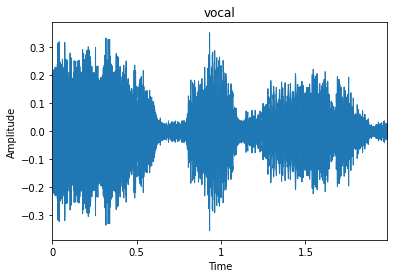

In [23]:
librosa.display.waveplot(mag, sr=SR)
plt.title('vocal')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


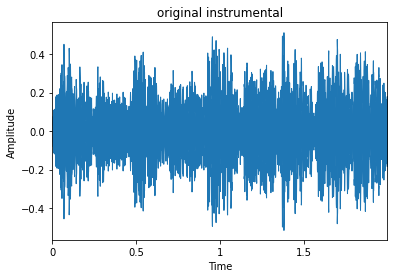

In [24]:
librosa.display.waveplot(original_signal, sr=SR)
plt.title('original instrumental')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

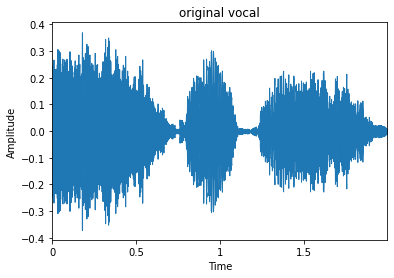

In [25]:
librosa.display.waveplot(original_signal_vocal, sr=SR)
plt.title('original vocal')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


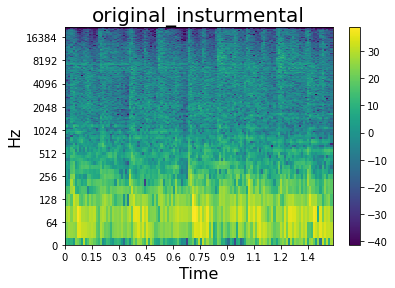

In [26]:
spectrogram = stft(original_signal, n_fft=window_size, hop_length=hop_length)
plt.title('original_insturmental', fontsize=20)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Hz", fontsize=16)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(spectrogram)), sr = SR, x_axis = 'time', y_axis = 'log',cmap='viridis')
plt.colorbar()

In [27]:
import math
def signaltonoise(signal,noise):
    signal_amplitude = np.sum(np.square(signal))
    
    noise_amplitude = np.sum(np.square(noise))
    
    SNR = 10*math.log10(signal_amplitude/noise_amplitude)
    return SNR

In [28]:
SNR = signaltonoise(original_signal_back,np.subtract(original_signal_back,mag))
print('snr: ',SNR)

snr:  -0.918871503597807


In [29]:
def cosine_similarity(x,y):
    numerator = np.sum(np.multiply(x,y))
    denominator = math.sqrt(np.sum(np.square(x))*np.sum(np.square(y)))
    return numerator/denominator

In [30]:
similarity= cosine_similarity(np.abs(original_signal_back),np.abs(mag))
print('similarity: ',similarity)

similarity:  0.5873974023494443
